# **<font color=#0b5bdb> Project name: Performance analysis </font>**

 <div class="alert alert-block alert-info"> 
 
 **Generic ML workflow**
 </div>
 
 
 - Get the data
 - Define (a) target(s)
 - Explore the data:
     - Know your dataset
     - Visualise the target(s)
     - Features: numerical, categorical, what they mean and correspond to
     - Spot missing values, aberrant values
     - Relationship between features, and between features and target, important features
- Clean the data:
    - Fix aberrant values
    - Retrieve missing values if possible
    - Keep only relevant features
- Preprocessing:
    - Split the data into a train and test set. The test set shall be kept aside and only used to evaluate the model
    - All the transformers shall be fitted on **the train set only**, not on the whole dataset
    - Imputation of missing values, try different strategies:
        - drop
        - median
        - mean
        - algorithm based
    - Encode categorical features
    - Normalise numerical values if needed
    - Build a simple, out-of-the-box model to have a basis to evaluate modifications, using cross validation
    - Try different imputation strategies
    - Feature selection:
        - Try different combination of features
        - Remove multicollinearity
    - Feature engineering:
        - Try new features created from original ones (polynomial expansion...)
    - Iterate over the above steps and pick what gives the best performance using the cross-validation score. **Test score shouldn't be used** for this purpose
- Model selection:
    - After carrying out the above, train various models using the optimal combination found and pick the best performing one(s), using the **cross validation score**
- Model optimisation:
    - Tune the model hyperparameters to maximise the **cross validation score**
- Assess the final model on the test set to get an unbiased estimate of its performance

- Scores and metrics:
    - Train score: computed on the train set
    - Cross validation score: computed on the train set, using k-fold cross validation score
    - Test scores : computed on the test set
    - Different metrics can be used depending on the problem:
        - Classification: ROC curve + AUC, F1 score, precision, recall
        - Regression: R$^{2}$, MAE, MSE, RMSE, MAPE,...
- Models are mainly used for analysis purposes and not in production

<div class="alert alert-block alert-warning">
    
**Good practice:**
</div>



- Set `random_state` in the methods that have this parameter to ensure reproducible results
- Normalise numerical features when not using tree-based methods
- Avoid data leakage from the train set to the test set, __do not__ fit transformers on the test set
    


This notebook covers the exploratory data analysis on a performance dataset.

## **Import modules and upload the dataset** 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import warnings
import altair as alt
warnings.filterwarnings('ignore')

In [2]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
# dataset path
file_path = "data/performance_data.csv"

# reading our dataset as a dataframe
df_cell = pd.read_csv(file_path)

# taking a first look on our data
df_cell.head()

,Sample_ID,Tool Type,Tray Number,Power (W),Pressure (mTorr),Ar Flow (sccm),Deposition Time (min),Substrate Temp (°C),Target
0,A1,Tool A,Tray1,200.0,3.4,49.0,18.0,193.0,352
1,A2,Tool A,Tray2,200.0,3.1,44.0,23.0,167.0,388
2,A3,Tool B,Tray1,250.0,3.0,43.0,20.0,196.0,368
3,A4,Tool B,Tray2,300.0,2.7,48.0,25.0,194.0,400
4,A5,Tool A,Tray1,220.0,2.9,41.0,24.0,176.0,393


<font color=#0b5bdb> **Dataset Description:**</font>
- **Sample_ID:** Sample name
- **Tool Type:** Tool A or Tool B
- **Tray Number:** Tray1 and Tray2
- **Power (W):** Sputtering power applied during deposition
- **Pressure (mTorr):**     Chamber pressure during sputtering
- **Ar Flow (sccm):** Argon gas flow rate
- **Deposition Time (min):** Duration of deposition process
- **Substrate Temp (°C):** Temperature of substrate during deposition
- **Target:** Thickness of deposited Al:ZnO layer 

<font color=#0b5bdb>**Introduce cfind- Useful function to search the columns you are interested**</font>

In [4]:
def cfind(column_name, dataframe):
    # Specify the prefixes you want to search for using wildcards (case-insensitive)
    prefixes_to_search = [column_name]

    # Filter columns with the specified prefixes (case-insensitive)
    filtered_columns = dataframe.filter(regex='|'.join(prefixes_to_search), axis=1)

    print(list[filtered_columns.columns])

In [5]:
cfind("Jsc", df_cell)

list[Index([], dtype='object')]


In [6]:
list(df_cell.columns)

['Sample_ID',
 'Tool Type',
 'Tray Number',
 'Power (W)',
 'Pressure (mTorr)',
 'Ar Flow (sccm)',
 'Deposition Time (min)',
 'Substrate Temp (°C)',
 'Target']

## **Details of dataset** 

In [7]:
# num of rows x num of columns
print('Dataset Dimensions:',df_cell.shape)

print('----------------------------------------')
print('----------------------------------------')
# types of each column
print(df_cell.dtypes)
print('----------------------------------------')
print('----------------------------------------')

Dataset Dimensions: (34, 9)
----------------------------------------
----------------------------------------
Sample_ID                 object
Tool Type                 object
Tray Number               object
Power (W)                float64
Pressure (mTorr)         float64
Ar Flow (sccm)           float64
Deposition Time (min)    float64
Substrate Temp (°C)      float64
Target                     int64
dtype: object
----------------------------------------
----------------------------------------


## **Clean the duplicates** 

In [8]:
# Identify duplicate rows based on 'Column1' and 'Column2'
duplicates = df_cell.duplicated(subset=['Sample_ID', "Tool Type"], keep='last')

# Create a new DataFrame without duplicates
df_cell = df_cell[~duplicates]

## **Check for null counts and percentages** 

In [9]:
df_cell.isnull()
# Count null values in each column
null_counts = df_cell.isnull().sum()

print("Null values in each column:")
print(null_counts)

# Count null values as a percentage in each column
null_percentages = (df_cell.isnull().mean() * 100).round(2)

print("Percentage of null values in each column:")
print(null_percentages)

Null values in each column:
Sample_ID                0
Tool Type                0
Tray Number              0
Power (W)                1
Pressure (mTorr)         0
Ar Flow (sccm)           2
Deposition Time (min)    1
Substrate Temp (°C)      1
Target                   0
dtype: int64
Percentage of null values in each column:
Sample_ID                0.00
Tool Type                0.00
Tray Number              0.00
Power (W)                2.94
Pressure (mTorr)         0.00
Ar Flow (sccm)           5.88
Deposition Time (min)    2.94
Substrate Temp (°C)      2.94
Target                   0.00
dtype: float64


<font color=#0b5bdb>**Check the heat map. I like to use altair module here**</font>

In [10]:
# Reshape the dataframe for the heatmap
df_cell_melted = pd.melt(df_cell, var_name='columns', value_name='value', ignore_index=False)
df_cell_melted['index'] = df_cell_melted.index
df_cell_melted_merged = pd.concat([df_cell_melted[["columns"]], df_cell_melted[["value"]].isnull(), df_cell_melted[["index"]]], axis=1)

# Create a heatmap using Altair
heatmap = alt.Chart(df_cell_melted_merged).mark_rect().encode(
    x=alt.X('index:N', title=None),
    y=alt.Y('columns:N', title=None,  axis=alt.Axis(labelFontSize=12)),
    color=alt.Color("value:N", scale=alt.Scale(domain=[True, False],
                     range=['yellow', 'black']))
)

# Display the heatmap
heatmap.properties(width=600, height=200)

alt.Chart(...)

**There are only few null values in our dataset!**

There are three methods to approach:
- 1. Removing 
- 2. Imputing
- 3. Masking
 
We can check the percentage of missing values for each column.
If the percentage is more than 50%, the column is removed. If less, then it is replaced by mean

In [11]:
for column in df_cell.columns:
    if df_cell[column].dtype == "float64" or df_cell[column].dtype == "int64":
        null_percentage = null_percentages[column]

        if null_percentage < 50:
            # Replace null values in the column with a specific value
            df_cell[column].fillna(value=df_cell[column].mean(), inplace=True)
        else:
            # Discard rows where null percentage is above 50%
            df_cell = df_cell.drop([column], axis=1)

**Check the missing values again**

In [12]:
# Reshape the dataframe for the heatmap
df_cell_melted = pd.melt(df_cell, var_name='columns', value_name='value', ignore_index=False)
df_cell_melted['index'] = df_cell_melted.index
df_cell_melted_merged = pd.concat([df_cell_melted[["columns"]], df_cell_melted[["value"]].isnull(), df_cell_melted[["index"]]], axis=1)

# Create a heatmap using Altair
heatmap = alt.Chart(df_cell_melted_merged).mark_rect().encode(
    x=alt.X('index:N', title=None),
    y=alt.Y('columns:N', title=None,  axis=alt.Axis(labelFontSize=12)),
    color=alt.Color("value:N", scale=alt.Scale(domain=[True, False],
                     range=['yellow', 'black']))
)

# Display the heatmap
heatmap.properties(width=600, height=200)

alt.Chart(...)

**We could also use seaborn module for this alternatively**

<Axes: >

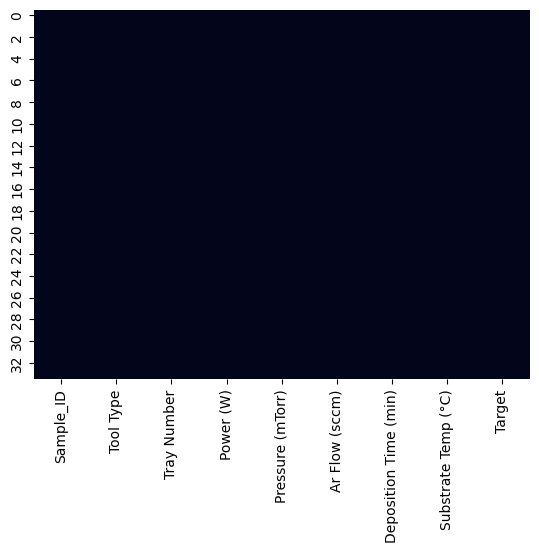

In [13]:
sns.heatmap(df_cell.isnull(), cbar=False)

## **Monitor the stats**

In [14]:
df_cell.describe()

,Power (W),Pressure (mTorr),Ar Flow (sccm),Deposition Time (min),Substrate Temp (°C),Target
count,34.00000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,230.30303,2.952941,46.718750,21.545455,175.272727,373.882353
std,46.99999,0.420847,3.702860,2.075702,13.471120,47.072970
min,120.00000,2.000000,41.000000,18.000000,152.000000,150.000000
25%,200.00000,2.725000,44.000000,20.000000,167.000000,364.250000
50%,230.00000,3.050000,46.859375,22.000000,174.136364,379.000000
75%,250.00000,3.275000,49.000000,23.000000,184.250000,387.750000
max,350.00000,3.600000,56.000000,25.000000,199.000000,500.000000


**The data shows some outlier for Efficiency. We need to filter those**

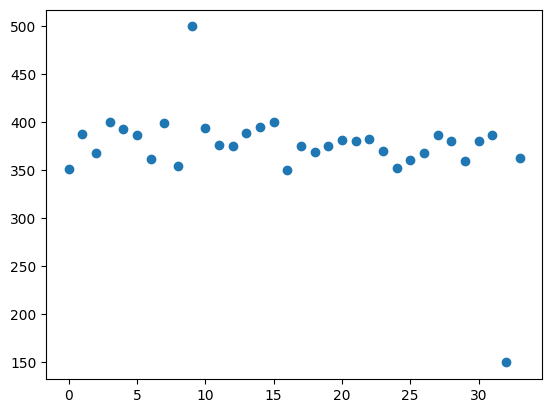

In [15]:
plt.scatter(df_cell.index, df_cell[['Target']])

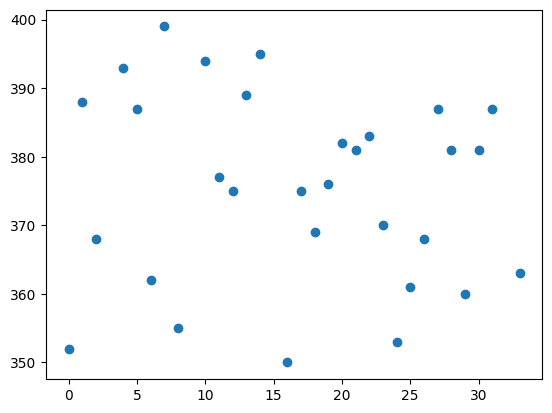

In [16]:
# Removing the rows with Target > 400 and less than < 250
df_cell = df_cell[df_cell['Target'] < 400]
df_cell = df_cell[df_cell['Target'] > 250]
plt.scatter(df_cell.index, df_cell[['Target']])

In [17]:
# Select just the rows desired from the 'describe' method and add in the 'median'
cell_X = df_cell.describe()
cell_X.loc['range'] = cell_X.loc['max'] - cell_X.loc['min']

stats = ['mean','25%','50%','75%', 'range']
cell_X = cell_X.loc[stats]
cell_X.rename({'50%': 'median'}, inplace=True)
cell_X

,Power (W),Pressure (mTorr),Ar Flow (sccm),Deposition Time (min),Substrate Temp (°C),Target
mean,225.010101,2.956667,46.581250,21.251515,174.042424,375.366667
25%,200.000000,2.825000,44.000000,20.000000,165.500000,364.250000
median,220.000000,3.050000,46.859375,21.272727,171.500000,376.500000
75%,250.000000,3.275000,49.000000,23.000000,181.750000,387.000000
range,230.000000,1.600000,15.000000,7.000000,47.000000,49.000000


**List of all categorical data in dataset**

In [18]:
categorical_columns = [colname for colname in df_cell.columns if df_cell[colname].dtype == "object"]
categorical_columns

['Sample_ID', 'Tool Type', 'Tray Number']

In [19]:
for col in categorical_columns:
    print("# unique values in '{0}': {1}".format(col, len(df_cell[col].unique().tolist())))

# unique values in 'Sample_ID': 30
# unique values in 'Tool Type': 2
# unique values in 'Tray Number': 2


**Calculate mean of the numerical columns based on grouping by categorical columns**

In [20]:
df_cell.groupby('Tool Type').mean()

,Power (W),Pressure (mTorr),Ar Flow (sccm),Deposition Time (min),Substrate Temp (°C),Target
Tool Type,,,,,,
Tool A,208.768939,2.912500,46.687500,20.846591,172.704545,371.562500
Tool B,243.571429,3.007143,46.459821,21.714286,175.571429,379.714286


In [21]:
df_cell.groupby('Tray Number').mean()

,Power (W),Pressure (mTorr),Ar Flow (sccm),Deposition Time (min),Substrate Temp (°C),Target
Tray Number,,,,,,
Tray1,227.500000,2.881250,47.419922,20.971591,173.625000,372.562500
Tray2,222.164502,3.042857,45.622768,21.571429,174.519481,378.571429


<font color=#0b5bdb>**Data Visualization**</font>

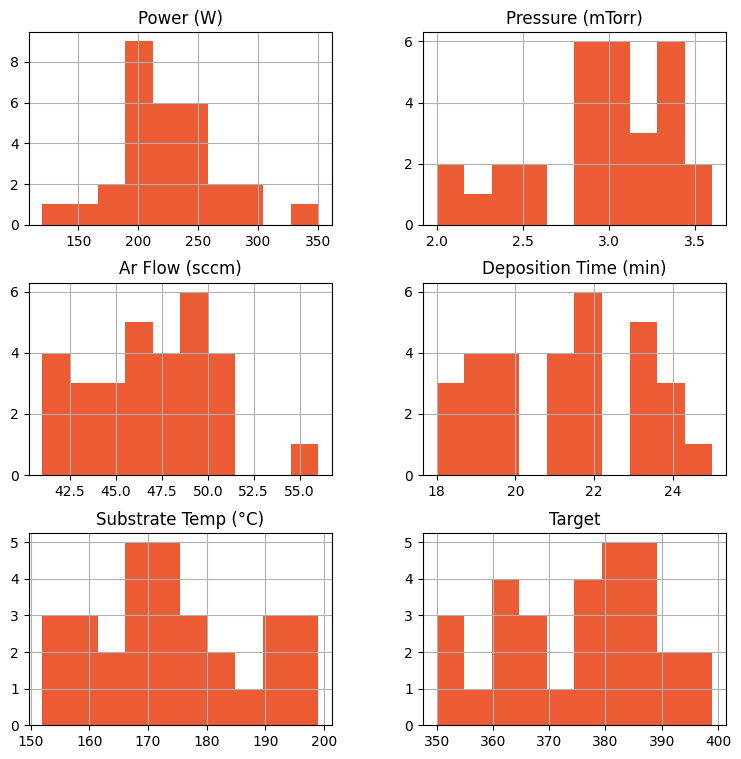

In [22]:
# Plotting Histogram for all numeric features
df_cell.hist(figsize=(9,9), color='#eb5b34')
plt.show()

**Another way to visualize the histograms**

In [23]:
import altair as alt

# Assuming df is your DataFrame from the previous example

# List to store individual plots
plots = []

# Loop through each feature
for feature in df_cell.columns:
    # Skip the categorical feature for now
    if feature == 'Category':
        continue
    
    # Create a distribution plot for each feature
    plot = alt.Chart(df_cell).mark_bar(opacity=0.5, color='green').encode(
        alt.X(f'{feature}:Q', bin=True),
        alt.Y('count()')
    ).properties(width=150, height=150)
    
    # Append the plot to the list
    plots.append(plot)

# Combine all plots into a single row
combined_plot = alt.concat(*plots, columns=3)

# Display the combined plot
combined_plot.interactive()

alt.ConcatChart(...)

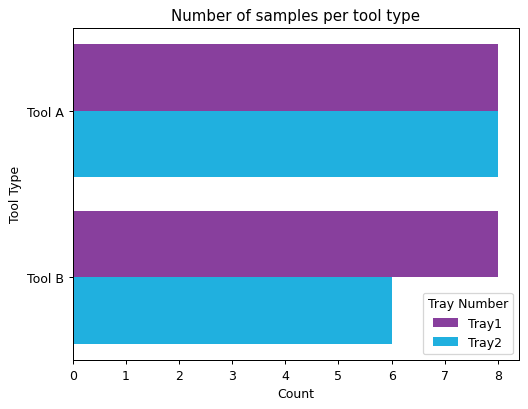

In [24]:
plt.figure(dpi=90)
sns.countplot(y ='Tool Type', hue = "Tray Number", data = df_cell, palette = sns.color_palette(['#902fad', '#00c0ff'])) 
plt.xlabel('Count')
plt.ylabel('Tool Type')
plt.title('Number of samples per tool type')
plt.show()

<Axes: xlabel='Tool Type', ylabel='Target'>

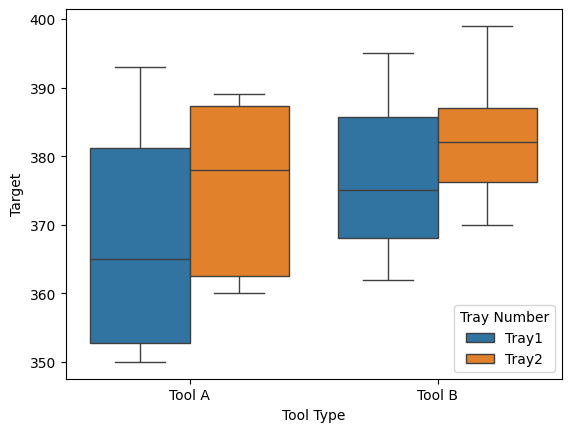

In [25]:
tray_order = ["Tray1", "Tray2"]
sns.boxplot(x='Tool Type', y="Target", hue='Tray Number', hue_order=tray_order, data=df_cell)

In [26]:
list(df_cell.columns)

['Sample_ID',
 'Tool Type',
 'Tray Number',
 'Power (W)',
 'Pressure (mTorr)',
 'Ar Flow (sccm)',
 'Deposition Time (min)',
 'Substrate Temp (°C)',
 'Target']

In [29]:
source = df_cell
ax_x = 'Deposition Time (min)'
ax_y = 'Target'
ax_l = 'Tool Type'

chart = alt.Chart(source).mark_circle().encode(
    x=alt.X(ax_x, axis=alt.Axis(labelFontSize=20.0,titleFontSize=20.0), scale=alt.Scale(domain=[10, 30])),
    y=alt.Y(ax_y, axis=alt.Axis(labelFontSize=20.0,titleFontSize=20.0), scale=alt.Scale(domain=[300, 450])),
    color=alt.Color(ax_l, legend=alt.Legend(titleFontSize=15, labelFontSize=15), scale=alt.Scale(scheme="plasma")),
    size=alt.value(60.0))
reg = chart.transform_regression(ax_x, ax_y, groupby=[ax_l]).mark_line(strokeWidth=5).encode(size=alt.value(3.0))

total_graph = chart + reg

total_graph.configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=10,
    labelLimit = 200
).interactive()

alt.LayerChart(...)

In [30]:
source1 = df_cell
ax_x = 'Power (W)'
ax_y = 'count()'
ax_label = 'Tray Number'
col_label = "Tool Type"
label_order = ['Tray1', "Tray2"]

graph1 = alt.Chart(source1).mark_bar(opacity=0.5, thickness=100).encode(
    x= alt.X(ax_x, axis=alt.Axis(labelFontSize=20)).bin(step=10),
    y= alt.Y(ax_y,axis=alt.Axis(labelFontSize=20)),
    color = alt.Color(ax_label, legend=alt.Legend(titleFontSize=20, labelFontSize=20, values=label_order), scale=alt.Scale(scheme="plasma")),
    column = alt.Column(col_label, header=alt.Header(labelFontSize=20))
).configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=10,
    labelLimit = 200
).configure_axis(
    titleFontSize=20.0
)
graph1.interactive()

alt.Chart(...)

## **Explore features**

<font color=#0b5bdb>**1. Finding the correlations between the features.**</font>

In [31]:
np.round(df_cell.corr(),1)

,Power (W),Pressure (mTorr),Ar Flow (sccm),Deposition Time (min),Substrate Temp (°C),Target
Power (W),1.0,0.1,0.1,0.6,0.4,0.6
Pressure (mTorr),0.1,1.0,-0.0,0.1,-0.2,0.1
Ar Flow (sccm),0.1,-0.0,1.0,-0.3,-0.1,-0.2
Deposition Time (min),0.6,0.1,-0.3,1.0,0.1,0.9
Substrate Temp (°C),0.4,-0.2,-0.1,0.1,1.0,0.2
Target,0.6,0.1,-0.2,0.9,0.2,1.0


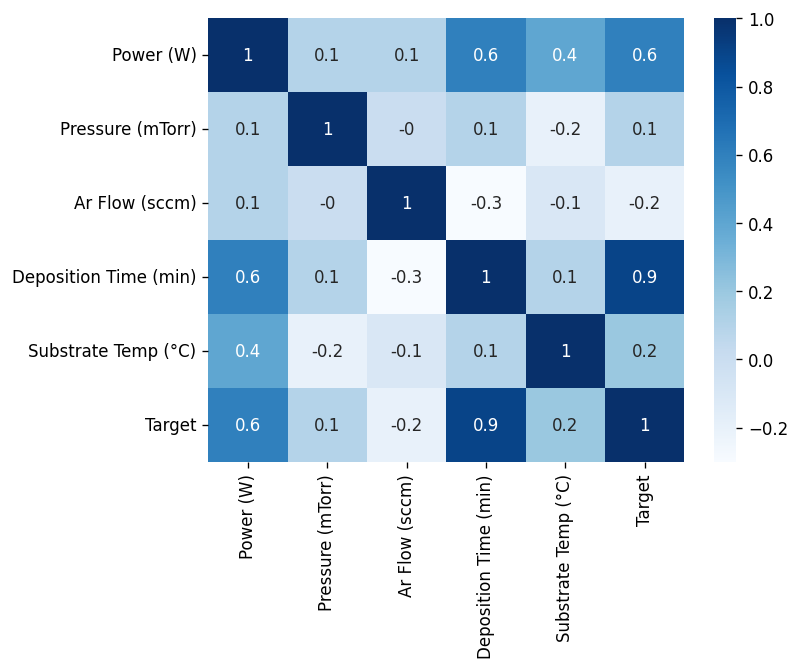

In [32]:
plt.figure(dpi=120)
sns.heatmap(np.round(df_cell.corr(),1),annot=True, cmap="Blues")
plt.show()

**Alternatively, we can use altair for this plot**

In [33]:
# Calculating the correlation matrix
correlation_matrix = df_cell.corr()

# Reshape the correlation matrix for Altair
correlation_matrix = correlation_matrix.stack().reset_index(name='correlation').rename(columns={'level_0': 'feature1', 'level_1': 'feature2'})

# Create a heatmap using Altair
heatmap = alt.Chart(correlation_matrix).mark_rect().encode(
    x='feature1:N',
    y='feature2:N',
    color=alt.Color('correlation:Q', legend=alt.Legend(titleFontSize=20, labelFontSize=20)),
    tooltip=['feature1:N', 'feature2:N', 'correlation:Q']
).properties(
    title='Correlation Heatmap with Numbers'
)

# Add text labels with correlation values
text = heatmap.mark_text(baseline='middle').encode(
    text=alt.Text('correlation:Q', format='.1f'),
    color=alt.condition(
        'datum.correlation > 0.5',
        alt.value('white'),
        alt.value('black')
    ),
    size=alt.value(20.0)  # You can adjust the font size here
)

# Combine the heatmap and text
heatmap_with_text = (heatmap + text).properties(width=300, height=300).configure_axis(
    labelFontSize=20.0,
    titleFontSize=20.0
).configure_title(
    fontSize=20,
    color='gray'
)

heatmap_with_text.properties(width=500, height=500)

alt.LayerChart(...)

In [34]:
# sorting features according to the strength of corretlation with target
np.round(df_cell.corr()[df_cell.columns[-1]].sort_values(ascending = False),1)

Target                   1.0
Deposition Time (min)    0.9
Power (W)                0.6
Substrate Temp (°C)      0.2
Pressure (mTorr)         0.1
Ar Flow (sccm)          -0.2
Name: Target, dtype: float64

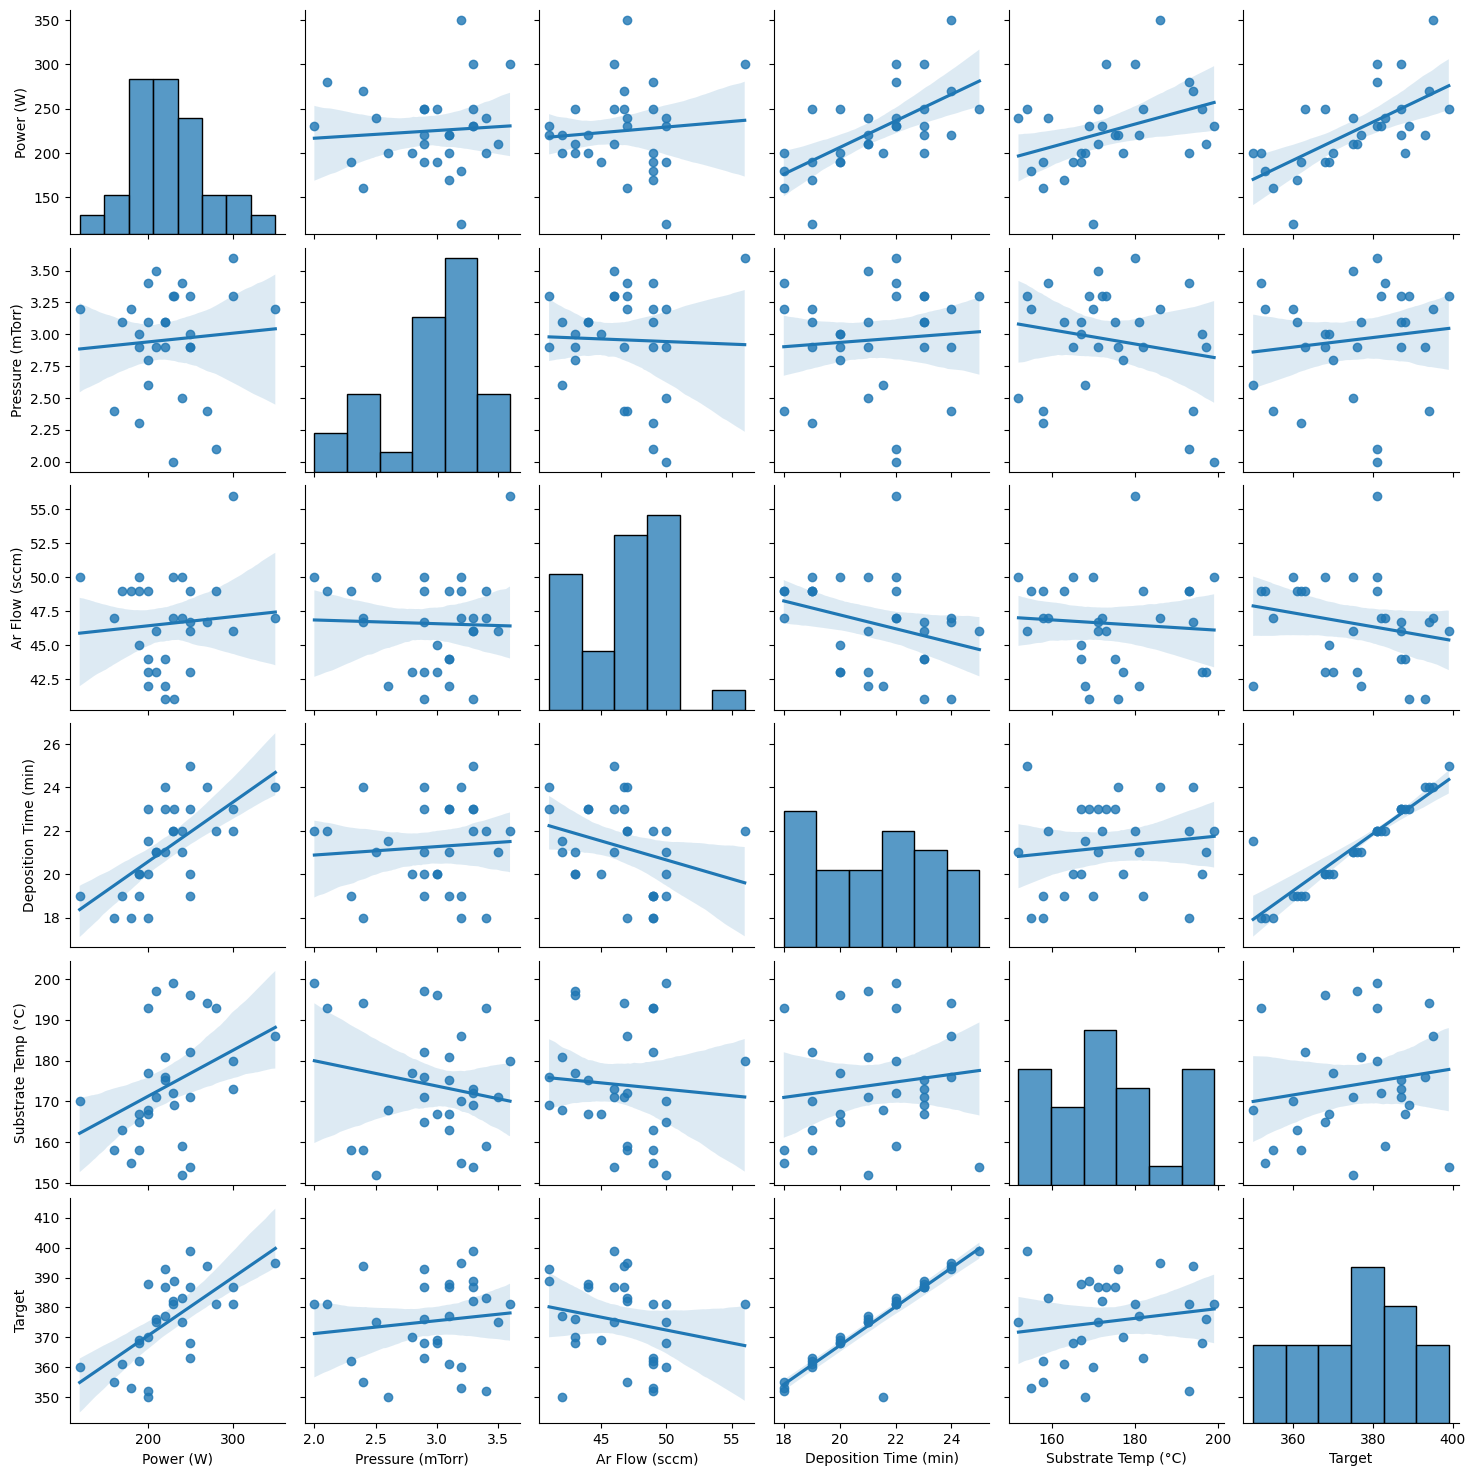

In [35]:
sns.pairplot(df_cell,kind = "reg")

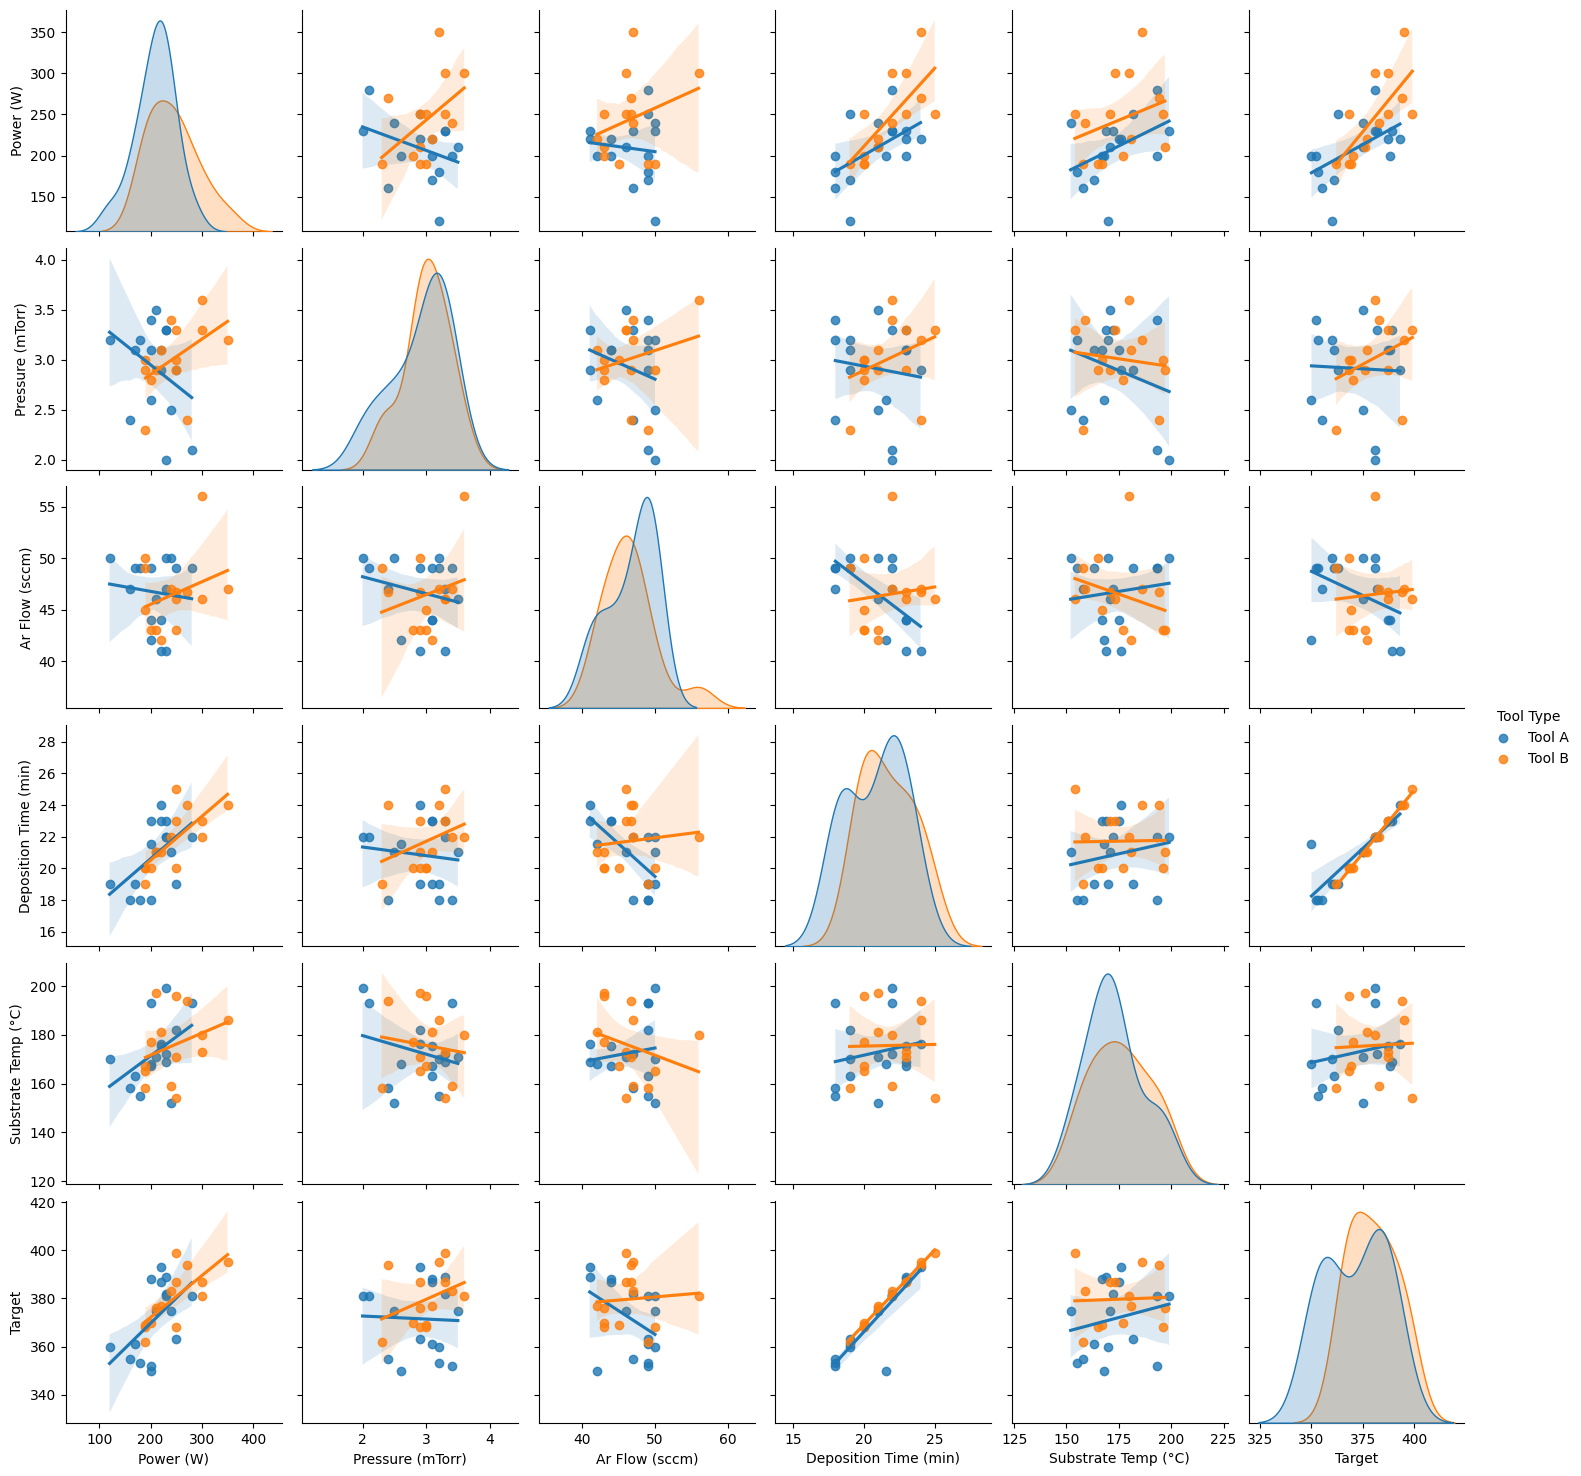

In [36]:
#Seperating the Tool Type
sns.pairplot(df_cell, hue= "Tool Type", kind = "reg")

In [37]:
# Save the dataframe to a CSV file
df_cell.to_csv('performance_data_cleaned.csv', index=False)